# Модуль А
## 1. Загрузка карт

In [22]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
import numpy as np
import os
import glob
from shapely.geometry import box
from rasterio.mask import mask

In [23]:
# Загружаем необходимые слои
etalons = gpd.read_file('Data/reprojected-wgs84/wgs84-etalons.shp')
forestry_bounds = gpd.read_file('Data/reprojected-wgs84/wgs84-forestry-bounds.shp')
etalons_clearcuts = gpd.read_file('Data/reprojected-wgs84/wgs84-etalons-clearcuts.shp')

In [3]:
# Объединяем слои
full_map = gpd.GeoDataFrame(pd.concat([etalons, forestry_bounds, etalons_clearcuts], ignore_index=True))

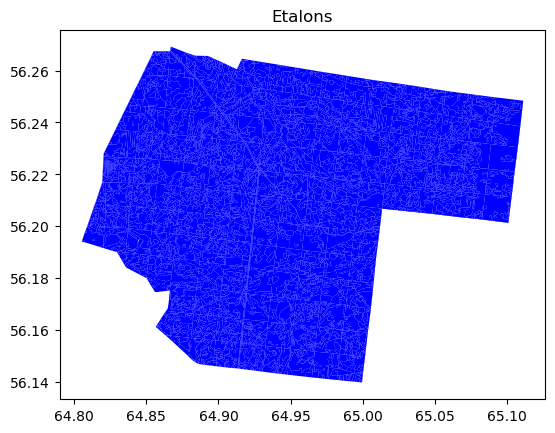

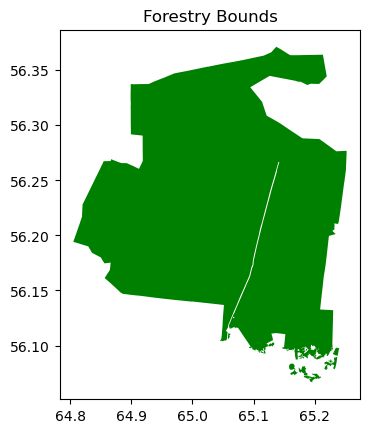

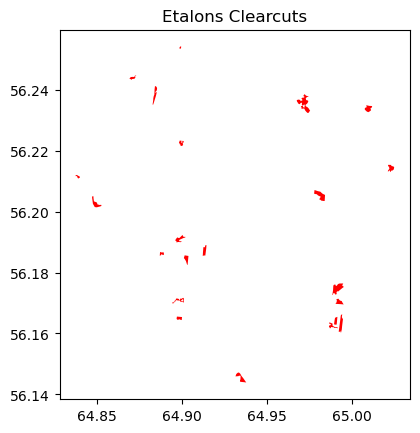

In [5]:
# Plot each layer separately
etalons.plot(color='blue')
plt.title('Etalons')
plt.show()

forestry_bounds.plot(color='green')
plt.title('Forestry Bounds')
plt.show()

etalons_clearcuts.plot(color='red')
plt.title('Etalons Clearcuts')
plt.show()

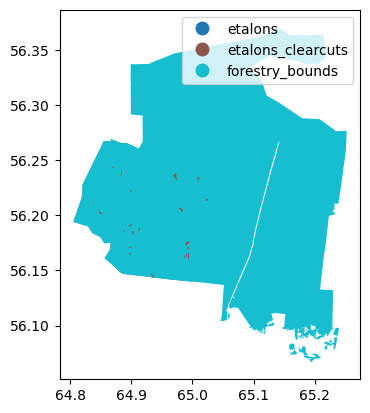

In [6]:
# Новая колонка для слоёв
full_map['layer'] = ['etalons'] * len(etalons) + ['forestry_bounds'] * len(forestry_bounds) + ['etalons_clearcuts'] * len(etalons_clearcuts)

# Выводим
full_map.plot(column='layer', categorical=True, legend=True)
plt.show()

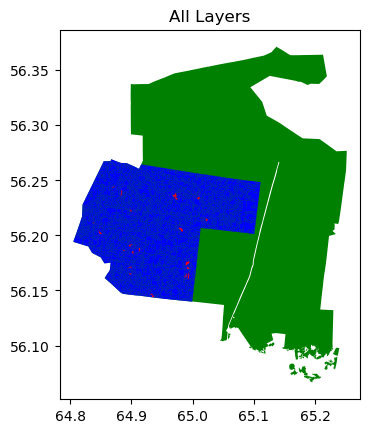

In [9]:
# Выводим три слоя
fig, ax = plt.subplots()

etalons.plot(ax=ax, color='blue', label='Etalons', zorder=10)
forestry_bounds.plot(ax=ax, color='green', label='Forestry Bounds')
etalons_clearcuts.plot(ax=ax, color='red', label='Etalons Clearcuts', zorder=15)

plt.title('All Layers')
plt.show()

## 2. Загрузка исходных данных и подготовка данных к анализу

In [5]:
directory = 'D:/new/'

# Получаем список всех tif файлов
files = glob.glob(os.path.join(directory, '*.tif'))

# Загружаем только первые 50
files = files[:5]

# Загрузка
datasets = []
shapes = []
transforms = []
for file in files:
    with rasterio.open(file) as src:
        datasets.append(src.read(1))
        shapes.append(src.shape)
        transforms.append(src.transform)

#### Я загружаю только 50 снимков, потому что датасет очень большой  (141 гб) и мощностей не хватит для обработки столь большого массива данных. Также при последующей обработке могут возникать MemoryError

In [117]:
datasets

[array([[ 54,  52,  49, ...,  81,  75,  66],
        [ 54,  57,  52, ...,  93,  84,  84],
        [ 47,  53,  50, ...,  91,  86,  87],
        ...,
        [ 93, 100,  88, ...,  62,  53,  47],
        [ 80,  78,  73, ...,  53,  50,  49],
        [ 78,  72,  74, ...,  57,  57,  49]], dtype=uint8),
 array([[526, 509, 482, ..., 799, 732, 641],
        [525, 559, 512, ..., 886, 820, 810],
        [468, 509, 484, ..., 892, 830, 857],
        ...,
        [907, 977, 861, ..., 601, 547, 455],
        [788, 777, 725, ..., 530, 496, 478],
        [751, 733, 718, ..., 522, 522, 504]], dtype=uint16),
 array([[ 65,  62,  59, ...,  94,  80,  74],
        [ 65,  64,  58, ..., 108,  92,  94],
        [ 58,  60,  61, ..., 104,  97,  98],
        ...,
        [112, 125, 112, ...,  69,  64,  61],
        [101, 100,  94, ...,  60,  59,  64],
        [ 92,  89,  92, ...,  61,  66,  64]], dtype=uint8),
 array([[ 642,  607,  578, ...,  917,  794,  715],
        [ 625,  630,  561, ..., 1060,  904,  929],
   

In [6]:
max_shape = (max(shapes, key=lambda x: x[0])[0], max(shapes, key=lambda x: x[1])[1])

padded_datasets = []
for dataset, shape in zip(datasets, shapes):
    padded_dataset = np.zeros(max_shape)
    padded_dataset[:shape[0], :shape[1]] = dataset
    padded_datasets.append(padded_dataset)

In [8]:
composite = np.stack(padded_datasets, axis=-1)

In [19]:
valid_shapes = []

for geom, value in [(etalons.geometry, 1), (forestry_bounds.geometry, 2), (etalons_clearcuts.geometry, 3)]:
    for g in geom:
        if g is not None and g.is_valid:
            valid_shapes.append((g, value))
        elif g is None:
            print("Empty geometry object found")
        else:
            print(f"Invalid geometry object: {g}")

out_shape = composite.shape[:2]

mask = rasterio.features.rasterize(
    valid_shapes,
    out_shape=out_shape,
    transform=transforms[0],
    all_touched=True,
    default_value=0
)

Empty geometry object found
Empty geometry object found


In [99]:
etalons.columns

Index(['Kv', 'Sknr', 'Kf1', 'Mr1', 'Amz1', 'H1', 'D1', 'Skal1', 'Tur1h1',
       'Kf2', 'Mr2', 'Amz2', 'H2', 'D2', 'Skal2', 'Tur1h2', 'Kf3', 'Mr3',
       'Amz3', 'H3', 'D3', 'Skal3', 'Tur1h3', 'Kf4', 'Mr4', 'Amz4', 'H4', 'D4',
       'Skal4', 'Tur1h4', 'Kf5', 'Mr5', 'Amz5', 'H5', 'D5', 'Skal5', 'Tur1h5',
       'geometry'],
      dtype='object')

In [105]:
for index, row in etalons.iterrows():
    print(row['Kv'])

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
16
1

In [17]:
etalons = etalons.dropna(subset=['geometry'])
forestry_bounds = forestry_bounds.dropna(subset=['geometry'])
etalons_clearcuts = etalons_clearcuts.dropna(subset=['geometry'])

In [79]:
import cv2
import numpy as np

# Load the TIF image
img_path = 'D:/image.tif'
img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)

if img is None:
    print("Error: Unable to load image!")
else:
    # Define the augmentation functions
    def rotate_image(img, angle):
        (h, w) = img.shape[:2]
        (cX, cY) = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
        return cv2.warpAffine(img, M, (w, h))

    def flip_image(img, flip_code):
        return cv2.flip(img, flip_code)

    def scale_image(img, scale_factor):
        return cv2.resize(img, (0, 0), fx=scale_factor, fy=scale_factor)

    # Apply augmentations
    augmented_images = []
    for _ in range(5):  # Create 5 augmented images
        img_aug = img.copy()
        img_aug = rotate_image(img_aug, np.random.uniform(-30, 30))  # Random rotation
        img_aug = flip_image(img_aug, np.random.randint(0, 2))  # Random flipping
        img_aug = scale_image(img_aug, np.random.uniform(0.8, 1.2))  # Random scaling
        augmented_images.append(img_aug)

    # Save the augmented images
    for i, img_aug in enumerate(augmented_images):
        cv2.imwrite(f'augmented_image_{i}.tif', img_aug)

Error: Unable to load image!


In [43]:
etalons_clearcuts

,код,тип_к?,площа,код_с?,код_л?,код_?,код_?_1,субъе,лесни,уч_ле?,...,ущерб,наруш,вид_о?,резул,номе_2,дата_4,приме,приро,objectid,geometry
0,43100020101080201,Граница лесосеки по материалам отвода,3.8,43,10,002,01,Курганская область,Шатровское,Бариновское,...,0.0,Без нарушения,Не установлен,Не проводилась,0,None,"Рубка на арендованном лесном участке, включенн...",None,12334,"POLYGON ((64.89589 56.19062, 64.89668 56.19127..."
1,43100020101090101,Граница лесосеки по материалам отвода,3.5,43,10,002,01,Курганская область,Шатровское,Бариновское,...,0.0,Без нарушения,Не установлен,Не проводилась,0,None,"Рубка на арендованном лесном участке, включенн...",None,12336,"POLYGON ((64.91431 56.189, 64.91417 56.18794, ..."
2,43100020101180201,Граница лесосеки по материалам отвода,1.4,43,10,002,01,Курганская область,Шатровское,Бариновское,...,0.0,Без нарушения,Не установлен,Не проводилась,0,None,"Рубка на арендованном лесном участке, включенн...",None,12337,"POLYGON ((64.88695 56.18672, 64.88767 56.18667..."
3,43100020101180301,Граница лесосеки по материалам отвода,3.2,43,10,002,01,Курганская область,Шатровское,Бариновское,...,0.0,Без нарушения,Не установлен,Не проводилась,0,None,"Рубка на арендованном лесном участке, включенн...",None,12338,"POLYGON ((64.90145 56.18564, 64.90368 56.18544..."
4,43100020101240101,Граница лесосеки по материалам отвода,9.4,43,10,002,01,Курганская область,Шатровское,Бариновское,...,0.0,Без нарушения,Не установлен,Не проводилась,0,None,"Рубка на арендованном лесном участке, включенн...",None,12321,"POLYGON ((64.98932 56.17592, 64.99024 56.17611..."
5,43100020101240201,Граница лесосеки по материалам отвода,3.4,43,10,002,01,Курганская область,Шатровское,Бариновское,...,0.0,Без нарушения,Не установлен,Не проводилась,0,None,"Рубка на арендованном лесном участке, включенн...",None,12323,"POLYGON ((64.99039 56.1699, 64.99104 56.1702, ..."
6,43100020101260101,Граница лесосеки по материалам отвода,2.6,43,10,002,01,Курганская область,Шатровское,Бариновское,...,0.0,Без нарушения,Не установлен,Не проводилась,0,None,"Рубка на арендованном лесном участке, включенн...",None,12348,"POLYGON ((64.89405 56.17, 64.89446 56.17028, 6..."
7,43100020101320101,Граница лесосеки по материалам отвода,5.4,43,10,002,01,Курганская область,Шатровское,Бариновское,...,0.0,Без нарушения,Не установлен,Не проводилась,0,None,"Рубка на арендованном лесном участке, включенн...",None,12329,"POLYGON ((64.99363 56.16606, 64.99436 56.16633..."
8,43100020101320201,Граница лесосеки по материалам отвода,2.4,43,10,002,01,Курганская область,Шатровское,Бариновское,...,0.0,Без нарушения,Не установлен,Не проводилась,0,None,"Рубка на арендованном лесном участке, включенн...",None,12330,"POLYGON ((64.99014 56.16515, 64.99124 56.16541..."
9,43100020101320301,Граница лесосеки по материалам отвода,2.4,43,10,002,01,Курганская область,Шатровское,Бариновское,...,0.0,Без нарушения,Не установлен,Не проводилась,0,None,"Рубка на арендованном лесном участке, включенн...",None,12332,"POLYGON ((64.98687 56.1637, 64.98773 56.16341,..."


In [39]:
etalons_new

,Kv,Sknr,Kf1,Mr1,Amz1,H1,D1,Skal1,Tur1h1,Kf2,...,Skal4,Tur1h4,Kf5,Mr5,Amz5,H5,D5,Skal5,Tur1h5,geometry
0,1,3,0,000000,0,0.0,0,0.0,0,0,...,0.0,0,0,000000,0,0.0,0,0.0,0,"POLYGON ((64.85809 56.26744, 64.85822 56.26739..."
1,1,4,8,Б,65,23.0,26,0.6,170,2,...,0.0,0,0,000000,0,0.0,0,0.0,0,"POLYGON ((64.85459 56.26687, 64.85505 56.26742..."
2,1,5,0,000000,0,0.0,0,0.0,0,0,...,0.0,0,0,000000,0,0.0,0,0.0,0,"POLYGON ((64.86062 56.26735, 64.86188 56.26745..."
3,1,6,8,С,85,27.0,36,0.7,360,2,...,0.0,0,0,000000,0,0.0,0,0.0,0,"POLYGON ((64.86372 56.26719, 64.86444 56.26729..."
4,1,7,0,000000,0,0.0,0,0.0,0,0,...,0.0,0,0,000000,0,0.0,0,0.0,0,"POLYGON ((64.86595 56.26734, 64.86599 56.26665..."
5,1,8,7,С,100,28.0,40,0.7,360,2,...,0.0,0,0,000000,0,0.0,0,0.0,0,"POLYGON ((64.85193 56.26356, 64.8521 56.26322,..."
6,1,9,9,Б,10,5.0,4,0.4,10,1,...,0.0,0,0,000000,0,0.0,0,0.0,0,"POLYGON ((64.85861 56.26644, 64.85843 56.26602..."
7,1,10,6,Б,65,24.0,26,0.6,190,4,...,0.0,0,0,000000,0,0.0,0,0.0,0,"POLYGON ((64.85926 56.26655, 64.86103 56.26683..."
8,1,11,0,000000,0,0.0,0,0.0,0,0,...,0.0,0,0,000000,0,0.0,0,0.0,0,"POLYGON ((64.86103 56.26683, 64.86119 56.26685..."
9,1,12,9,С,100,29.0,36,0.7,400,1,...,0.0,0,0,000000,0,0.0,0,0.0,0,"POLYGON ((64.86263 56.26659, 64.86344 56.26661..."


## 3. Расширение набора данных с помощью методов аугментации

In [91]:
from PIL import Image, ImageEnhance
import numpy as np
import os

# Define the folder path and the number of files to process
folder_path = 'for_aug'
num_files = 10

# Get the list of TIF files in the folder
tif_files = [f for f in os.listdir(folder_path) if f.endswith('.tif')]

# Process each TIF file
for i, tif_file in enumerate(tif_files[:num_files]):
    img_path = os.path.join(folder_path, tif_file)
    img = Image.open(img_path)

    # Define the augmentation functions
    def rotate_image(img, angle):
        return img.rotate(angle)

    def flip_image(img, flip_code):
        if flip_code == 0:
            return img.transpose(Image.FLIP_LEFT_RIGHT)
        elif flip_code == 1:
            return img.transpose(Image.FLIP_TOP_BOTTOM)

    def scale_image(img, scale_factor):
        return img.resize((int(img.width * scale_factor), int(img.height * scale_factor)))

    # Apply augmentations
    augmented_images = []
    for _ in range(5):  # Create 5 augmented images
        img_aug = img.copy()
        img_aug = rotate_image(img_aug, np.random.uniform(-30, 30))  # Random rotation
        img_aug = flip_image(img_aug, np.random.randint(0, 2))  # Random flipping
        img_aug = scale_image(img_aug, np.random.uniform(0.8, 1.2))  # Random scaling

        # Convert 16-bit grayscale image to 8-bit grayscale image
        img_aug = img_aug.convert('L')

        # Convert 8-bit grayscale image to RGB mode
        img_aug = img_aug.convert('RGB')

        augmented_images.append(img_aug)

    # Save the augmented images
    for j, img_aug in enumerate(augmented_images):
        img_aug.save(f'augmented_image_{i}_{j}.jpg', quality=90)

C:\Users\BRICS\anaconda3\Lib\site-packages\PIL\Image.py:3218: DecompressionBombWarning: Image size (120560400 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


## 6. Отчёт

### 1. Загрузка карт

Были загружены 3 слоя, объеденены и визуализированы.

### 2. Загрузка исходных данных и подготовка данных к анализу

Был загружен не весь датасет, так как вес его был 140+ гб. На снимки были наложены маски с шейп-файлами. Это необходимо для последующего анализа

### 3. Расширение набора данных с помощью методов аугментации

Была проведена аугментация изображений из папки for_aug при помощи PIL
